# Generate mixture data

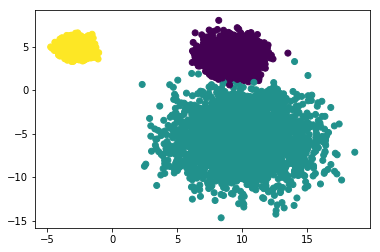

In [95]:
%matplotlib inline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

# Fix random seed
np.random.seed(24)

# Number of samples
N_SAMPLES = 10000
# Number of mixtures
K = 3

X, y = make_blobs(n_samples=N_SAMPLES, 
                  cluster_std=[1.0, 2.5, 0.5, 1.5, .8], 
                  centers=K)
# Set batch size for stochastic algorithms
batch_size=100
X_minibatch = pm.Minibatch(data=X, batch_size=batch_size)

X = X.astype('float32')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis);

# Kmeans and deterministic GMM

Text(0.5,1,u'kmean with 5 clusters')

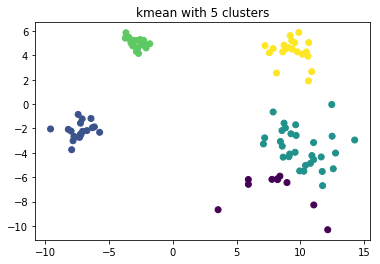

In [2]:
from sklearn.cluster import KMeans

y1 = KMeans(n_clusters=K, 
            # n_init
            # Number of time the k-means algorithm will be run with different centroid seeds. 
            # The final results will be the best output of
            n_init=50).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y1, cmap=plt.cm.viridis);
plt.title("kmean with {} clusters".format(K))

# NUTS 

In [97]:
import theano
import scipy.stats as stats
floatX = "float32"
from theano import shared

import theano.tensor as tt
import pymc3 as pm
from pymc3.math import logsumexp

# A linalg solver from theano.tensor
solver = tt.slinalg.Solve(A_structure="lower_triangular", lower=True)

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# Log likelihood of Gaussian mixture distribution
def GMM_logp(weight, mus, chol):
    def logp_(value):
        Ncomp = len(chol)
        logps = []
        for i in range(Ncomp):
            mu = mus[:, i]
            chol_cov = chol[i]
            k = chol_cov.shape[0]

            delta = value.reshape((-1, k)) - mu
            delta_trans = solver(chol_cov, delta.T)

            result = k * tt.log(2 * np.pi)
            result += 2.0 * tt.sum(tt.log(tt.nlinalg.diag(chol_cov)))
            result += (delta_trans ** 2).sum(axis=0).T
            logps.append(tt.log(weight[i]) + -0.5*result)
        return logsumexp(tt.stacklists(logps), axis=0)
    return logp_

# MAX_K << K 
MAX_K = 3

# Define the model
with pm.Model() as model:
    
    # The alpha parameter for the Dirichlet distribution
    alpha = pm.Gamma('alpha', alpha=1., beta=1., transform=None)
    # The beta parameter which samples from the Dirichlet distribution
    beta = pm.Beta('beta', 1., alpha, shape=MAX_K, transform=None)
    # A deterministic variable which is the weight for each item in the mixture
    w = pm.Deterministic('w', stick_breaking(beta))
    # Calculate                      
    sd_dist = []
    packed_chol = []
    chol = []
    for i in range(MAX_K):
        sd_dist.append(pm.HalfCauchy.dist(beta=2.5))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i, eta=2, n=2, sd_dist=sd_dist[i]))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
    
    mus = pm.Normal('mu', 0, sd=10, shape=(2, MAX_K))
    obs = pm.DensityDist('obs', GMM_logp(w, mus, chol), observed=X)
    
model    

### Final task
Our task is to find to estimate the quadratic function. We will test this by calculating L2 loss of the generated samples from the trained model to the observed output

In [96]:
from collections import OrderedDict
import warnings

from pymc3.step_methods.arraystep import Competence, ArrayStepShared
from pymc3.vartypes import continuous_types
from pymc3.model import modelcontext, inputvars
import theano.tensor as tt
from pymc3.theanof import tt_rng, make_shared_replacements, jacobian, floatX, inputs
import theano
import numpy as np

__all__ = ['SGFS', 'CSG']

EXPERIMENTAL_WARNING = "Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet"\
    " recommended for use in PyMC3!"


def _value_error(cond, str):
    """Throws ValueError if cond is False"""
    if not cond:
        raise ValueError(str)


def _check_minibatches(minibatch_tensors, minibatches):
    _value_error(
        isinstance(minibatch_tensors, list),
        'minibatch_tensors must be a list.')

    _value_error(
        hasattr(minibatches, "__iter__"), 'minibatches must be an iterator.')


def get_multi_obs_logp_elemwiset(model=None):
    """Calculate the elementwise log-posterior for the model.
    Handle case when there are more than one observed RVs

    Parameters
    ----------
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    logp_elemwiset : array of shape (n_samples, n_observations)
        The contribution of the observations to the logp of the whole model.
    """
    model = modelcontext(model)
    cached = [(var, var.logp_elemwiset) for var in model.observed_RVs]

    if len(cached) == 0:
        return floatX(np.array([], dtype='d'))

    logp_elemwiset = []
    for var, logp in cached:
        if var.missing_values:
            logp = logp[~var.observations.mask]
        logp_elemwiset.append(logp.ravel())
    return tt.concatenate(logp_elemwiset, axis=1)


def get_log_prior(model=None):
    """Calculate the elementwise log-prior for the model.

    Parameters
    ----------
    vars
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    log_prior : 0-D tensor
    """
    model = modelcontext(model)
    hierarchy = {rv: [var for var in model.free_RVs if var in rv.distribution.__dict__.values()] for rv in model.free_RVs}
    observed_rvs = [var for var in model.observed_RVs]
    logprior = [input_rv for obs_rv in observed_rvs for input_rv in inputs([obs_rv.logpt]) if
                input_rv in model.free_RVs]
    logprior = [item.logpt for free_rv in logprior for item in hierarchy[free_rv] + [free_rv]]
    return tt.sum(logprior)


def get_elemwise_dlogL(vars=None, model=None, flat_view=None):
    """
    Returns Jacobian of the log likelihood for each training datum wrt vars
    as a matrix of size N x D
    """
    # set model
    model = modelcontext(model)

    logp_elemwiset = get_multi_obs_logp_elemwiset(model)
    log_prior = get_log_prior(model)
    logL = logp_elemwiset + log_prior

    dlogp_elemwiset = jacobian(logp_elemwiset, vars)
    dlog_prior = jacobian(log_prior, vars).flatten()
    dlogL = jacobian(logL, vars)

    if flat_view is not None:
        dlogp_elemwiset = theano.clone(dlogp_elemwiset, flat_view.replacements, strict=False)
        dlog_prior = theano.clone(dlog_prior, flat_view.replacements, strict=False)
        dlogL = theano.clone(dlogL, flat_view.replacements, strict=False)

    return dlogp_elemwiset, dlog_prior, dlogL


class BaseStochasticGradient(ArrayStepShared):
    R"""
    BaseStochasticGradient Object

    For working with BaseStochasticGradient Object
    we need to supply the probabilistic model
    (:code:`model`) with the data supplied to observed
    variables of type `GeneratorOp`

    Parameters
    ----------
    vars : list
        List of variables for sampler
    batch_size`: int
        Batch Size for each step
    total_size : int
        Total size of the training data
    step_size : float
        Step size for the parameter update
    model : PyMC Model
        Optional model for sampling step. Defaults to None (taken from context)
    random_seed : int
        The seed to initialize the Random Stream
    minibatches : iterator
        If the ObservedRV.observed is not a GeneratorOp then this parameter must not be None
    minibatch_tensor : list of tensors
        If the ObservedRV.observed is not a GeneratorOp then this parameter must not be None
        The length of this tensor should be the same as the next(minibatches)

    Notes
    -----
    Defining a BaseStochasticGradient needs
    custom implementation of the following methods:
        - :code: `.mk_training_fn()`
            Returns a theano function which is called for each sampling step
        - :code: `._initialize_values()`
            Returns None it creates class variables which are required for the training fn
    """

    def __init__(self,
                 vars=None,
                 batch_size=None,
                 total_size=None,
                 step_size=1.0,
                 model=None,
                 random_seed=None,
                 minibatches=None,
                 minibatch_tensors=None,
                 **kwargs):
        warnings.warn(EXPERIMENTAL_WARNING)

        model = modelcontext(model)

        if vars is None:
            vars = model.vars

        vars = inputvars(vars)
        self.kwargs = kwargs
        self.model = model
        self.vars = vars
        self.batch_size = batch_size
        self.total_size = total_size
        _value_error(
            total_size != None or batch_size != None,
            'total_size and batch_size of training data have to be specified')
        self.expected_iter = int(total_size / batch_size)

        # set random stream
        self.random = None
        if random_seed is None:
            self.random = tt_rng()
        else:
            self.random = tt_rng(random_seed)

        self.step_size = step_size

        shared = make_shared_replacements(vars, model)

        self.updates = OrderedDict()
        self.q_size = int(sum(v.dsize for v in self.vars))

        flat_view = model.flatten(vars)
        self.inarray = [flat_view.input]

        self.dlogp_elemwise, self.dlog_prior, self.dlogL_elemwise = get_elemwise_dlogL(vars, model, flat_view)
        self.q_size = int(sum(v.dsize for v in self.vars))

        if minibatch_tensors != None:
            _check_minibatches(minibatch_tensors, minibatches)
            self.minibatches = minibatches

            # Replace input shared variables with tensors
            def is_shared(t):
                return isinstance(t, theano.compile.sharedvalue.SharedVariable)

            tensors = [(t.type() if is_shared(t) else t)
                       for t in minibatch_tensors]
            updates = OrderedDict({
                t: t_
                for t, t_ in zip(minibatch_tensors, tensors) if is_shared(t)
            })
            self.minibatch_tensors = tensors
            self.inarray += self.minibatch_tensors
            self.updates.update(updates)

        self._initialize_values()
        super(BaseStochasticGradient, self).__init__(vars, shared)

    def _initialize_values(self):
        """Initializes the parameters for the stochastic gradient minibatch
        algorithm"""
        raise NotImplementedError

    def mk_training_fn(self):
        raise NotImplementedError

    def training_complete(self):
        """Returns boolean if astep has been called expected iter number of times"""
        return self.expected_iter == self.t

    def astep(self, q0):
        """Perform a single update in the stochastic gradient method.

        Returns new shared values and values sampled
        The size and ordering of q0 and q must be the same
        Parameters
        -------
        q0: list
            List of shared values and values sampled from last estimate

        Returns
        -------
        q
        """
        if hasattr(self, 'minibatch_tensors'):
            return q0 + self.training_fn(q0, *next(self.minibatches))
        else:
            if self.kwargs['log']:
                print('q', q0.shape)            
                print('q', q0)
                print('dlog_prior', self.f2(q0).shape)
                print('dlog_prior', self.f2(q0))
                print('gt', self.f3(q0).shape)
                print('gt', self.f3(q0))
                print('inv_cov_mat', self.f4(q0).shape)
                print('inv_cov_mat', self.f4(q0))
                print('noise_coeff', self.f5(q0).shape)
                print('noise_coeff', self.f5(q0))
                print('dq', self.training_fn(q0).shape)
                print('dq', self.training_fn(q0))
            return q0 + self.training_fn(q0)


class SGFS(BaseStochasticGradient):
    R"""
    StochasticGradientFisherScoring

    Parameters
    ----------
    vars : list
        model variables
    B : np.array
        the pre-conditioner matrix for the fisher scoring step
    step_size_decay : int
        Step size decay rate. Every `step_size_decay` iteration the step size reduce 
        to the half of the previous step size
 
    References
    ----------
    -   Bayesian Posterior Sampling via Stochastic Gradient Fisher Scoring
        Implements Algorithm 1 from the publication http://people.ee.duke.edu/%7Elcarin/782.pdf
    """
    name = 'stochastic_gradient_fisher_scoring'

    def __init__(self, vars=None, B=None, step_size_decay=100, **kwargs):
        """
        Parameters
        ----------
        vars : list
            Theano variables, default continuous vars
        B : np.array
            Symmetric positive Semi-definite Matrix
        kwargs: passed to BaseHMC
        """
        self.B = B
        self.step_size_decay = step_size_decay
        super(SGFS, self).__init__(vars, **kwargs)

    def _initialize_values(self):
        # Init avg_I
        self.avg_I = theano.shared(
            np.zeros((self.q_size, self.q_size)), name='avg_I')
        self.t = theano.shared(1, name='t')
        # 2. Set gamma
        self.gamma = (self.batch_size + self.total_size) / (self.total_size)

        self.training_fn = self.mk_training_fn()

    def mk_training_fn(self):

        n = self.batch_size
        N = self.total_size
        q_size = self.q_size
        B = self.B
        gamma = self.gamma
        avg_I = self.avg_I
        t = self.t
        updates = self.updates
        epsilon = self.step_size / pow(2.0, t // self.step_size_decay)
        random = self.random
        inarray = self.inarray
        gt, dlog_prior = self.dlogp_elemwise, self.dlog_prior

        # 5. Calculate mean dlogp
        avg_gt = gt.mean(axis=0)

        # 6. Calculate approximate Fisher Score
        gt_diff = (gt - avg_gt)

        V = (1. / (n - 1)) * tt.dot(gt_diff.T, gt_diff)

        # 7. Update moving average
        I_t = (1. - 1. / t) * avg_I + (1. / t) * V

        if B is None:
            # if B is not specified
            # B \propto I_t as given in
            # http://www.ics.uci.edu/~welling/publications/papers/SGFS_v10_final.pdf
            # after iterating over the data few times to get a good approximation of I_N
            B = tt.switch(t <= int(N / n) * 50, tt.eye(q_size), gamma * I_t)

        # 8. Noise Term
        # The noise term is sampled from a normal distribution
        # of mean 0 and std_dev = sqrt(4B/step_size)
        # In order to generate the noise term, a standard
        # normal dist. is scaled with 2B_ch/sqrt(step_size)
        # where B_ch is cholesky decomposition of B
        # i.e. B = dot(B_ch, B_ch^T)
        B_ch = tt.slinalg.cholesky(B)
        noise_term = tt.dot((2.*B_ch)/tt.sqrt(epsilon), \
                random.normal((q_size,), dtype=theano.config.floatX))
        # 9.
        # Inv. Fisher Cov. Matrix
        cov_mat = (gamma * I_t * N) + ((4. / epsilon) * B)
        inv_cov_mat = tt.nlinalg.matrix_inverse(cov_mat)
        # Noise Coefficient
        noise_coeff = (dlog_prior + (N * avg_gt) + noise_term)
        dq = 2 * tt.dot(inv_cov_mat, noise_coeff)

        updates.update({avg_I: I_t, t: t + 1})

        f = theano.function(
            outputs=dq,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)
        
        self.f2 = theano.function(
            outputs=dlog_prior,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)
        
        self.f3 = theano.function(
            outputs=gt,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)

        self.f4 = theano.function(
            outputs=inv_cov_mat,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)

        self.f5 = theano.function(
            outputs=noise_coeff,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)

        return f

    @staticmethod
    def competence(var, has_grad):
        if var.dtype in continuous_types and has_grad:
            return Competence.COMPATIBLE
        return Competence.INCOMPATIBLE


class CSG(BaseStochasticGradient):
    R"""
    CSG: ConstantStochasticGradient
    
    It is an approximate stochastic variational inference algorithm
    while SGFS and many other MCMC techniques provably
    converge towards the exact posterior. The referenced paper 
    discusses a proof for the optimal preconditioning matrix
    based on variational inference, so there is no parameter tuning required
    like in the case of 'B' matrix used for preconditioning in SGFS.
    Take a look at this example notebook 
    https://github.com/pymc-devs/pymc3/tree/master/docs/source/notebooks/constant_stochastic_gradient.ipynb
     
    Parameters
    ----------
    vars : list
        model variables

    References
    ----------
    -   Stochastic Gradient Descent as Approximate Bayesian Inference
        https://arxiv.org/pdf/1704.04289v1.pdf
    """
    name = 'constant_stochastic_gradient'

    def __init__(self, vars=None, **kwargs):
        """
        Parameters
        ----------
        vars : list 
            Theano variables, default continuous vars
        kwargs: passed to BaseHMC
        """
        super(CSG, self).__init__(vars, **kwargs)

    def _initialize_values(self):
        # Init avg_C: Noise Covariance Moving Average
        self.avg_C = theano.shared(
            np.zeros((self.q_size, self.q_size)), name='avg_C')
        self.t = theano.shared(1, name='t')
        # Init training fn
        self.training_fn = self.mk_training_fn()

    def mk_training_fn(self):
        """The Constant Stochastic Gradient Step Fn with Optimal Preconditioning Matrix"""
        q_size = self.q_size
        avg_C = self.avg_C
        t = self.t
        updates = self.updates
        # Trying to stick to variables names as given in the publication
        # https://arxiv.org/pdf/1704.04289v1.pdf
        S = self.batch_size
        N = self.total_size

        # inputs
        random = self.random
        inarray = self.inarray

        # gradient of log likelihood
        gt = -1 * (1. / S) * (self.dlogp_elemwise.sum(axis=0) +
                              (S / N) * self.dlog_prior)

        # update moving average of Noise Covariance
        gt_diff = (self.dlogp_elemwise - self.dlogp_elemwise.mean(axis=0))
        V = (1. / (S - 1)) * theano.dot(gt_diff.T, gt_diff)
        C_t = (1. - 1. / t) * avg_C + (1. / t) * V
        # BB^T = C 
        B = tt.switch(t < 0, tt.eye(q_size), tt.slinalg.cholesky(C_t))
        # Optimal Preconditioning Matrix
        H = (2. * S / N) * tt.nlinalg.matrix_inverse(C_t)
        # step value on the log likelihood gradient preconditioned with H
        step = -1 * theano.dot(H, gt.dimshuffle([0, 'x']))

        # sample gaussian noise dW
        dW = random.normal(
            (q_size, 1), dtype=theano.config.floatX, avg=0.0, std=1.0)
        # noise term is inversely proportional to batch size
        noise_term = (1. / np.sqrt(S)) * theano.dot(H, theano.dot(B, dW))
        # step + noise term
        dq = (step + noise_term).flatten()

        # update time and avg_C 
        updates.update({avg_C: C_t, t: t + 1})

        f = theano.function(
            outputs=dq,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)

        return f

    @staticmethod
    def competence(var):
        if var.dtype in continuous_types:
            return Competence.COMPATIBLE
        return Competence.INCOMPATIBLE

In [99]:
# Define the model
with pm.Model() as model:
    
    # The alpha parameter for the Dirichlet distribution
    alpha = pm.Gamma('alpha', alpha=1., beta=1.)
    # The beta parameter which samples from the Dirichlet distribution
    beta = pm.Beta('beta', 1., alpha, shape=MAX_K)
    # A deterministic variable which is the weight for each item in the mixture
    w = pm.Deterministic('w', stick_breaking(beta))
    # Calculate                      
    sd_dist = []
    packed_chol = []
    chol = []
    for i in range(MAX_K):
        sd_dist.append(pm.HalfCauchy.dist(beta=2.5))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i, eta=2, n=2, sd_dist=sd_dist[i]))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
    
    mus = pm.Normal('mu', 0, sd=10, shape=(2, MAX_K))
    obs = pm.DensityDist('obs', GMM_logp(w, mus, chol), observed=X_minibatch)
    
model    

In [103]:
with model:
    step_method = SGFS(batch_size=batch_size, step_size=1.0, total_size=total_size, log=False)

/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/ipykernel_launcher.py:153: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!


In [137]:
last_point = [model.test_point]

In [138]:
last_point[-1]

{'alpha_log__': array(0.),
 'beta_logodds__': array([0., 0., 0.]),
 'chol_cov_0_cholesky_cov_packed__': array([0., 0., 0.]),
 'chol_cov_1_cholesky_cov_packed__': array([0., 0., 0.]),
 'chol_cov_2_cholesky_cov_packed__': array([0., 0., 0.]),
 'mu': array([[0., 0., 0.],
        [0., 0., 0.]])}

In [170]:
dPdV = pm.theanof.jacobian(get_multi_obs_logp_elemwiset(model), model.vars)
dPdV = theano.clone(strict=)

In [171]:
dLdV = pm.theanof.jacobian(get_multi_obs_logp_elemwiset(model) + get_log_prior(model), model.vars)

In [173]:
dPdV.eval(model.test_point)

TypeError: Unknown parameter type: <type 'str'>

In [164]:
step_method.dlogp_elemwise.eval({step_method.inarray[0]: model.bijection.map(last_point[0])})[0, :]

array([ 6.25609394,  3.12804697,  1.56402349,  2.16269008,  1.08134504,
        0.54067252, 16.98032911,  5.91937163,  1.90343027, 33.96065822,
       11.83874326,  3.80686054, 67.92131644, 23.67748652,  7.61372108,
        0.07142857,  0.07142857,  0.07142857,  0.        ])

In [163]:
step_method.dlogp_elemwise.eval({step_method.inarray[0]: model.bijection.map(last_point[0])})[0, :]

array([ 6.05411771,  3.02705885,  1.51352943,  2.68613925,  1.34306962,
        0.67153481, 15.89254214,  7.1147139 ,  3.01385589, 31.78508428,
       14.2294278 ,  6.02771177, 63.57016856, 28.45885559, 12.05542355,
        0.07142857,  0.07142857,  0.07142857,  0.        ])

In [162]:
step_method.dlogp_elemwise.eval({step_method.inarray[0]: model.bijection.map(last_point[0])})[0, :]

array([-1.57645024, -0.78822512, -0.39411256,  3.60330555,  1.80165278,
        0.90082639,  0.94441583, -2.48518896,  5.53756012,  1.88883166,
       -4.97037793, 11.07512025,  3.77766333, -9.94075585, 22.1502405 ,
        0.07142857,  0.07142857,  0.07142857,  0.        ])

In [149]:
step_method.dlogp_elemwise.eval({step_method.inarray[0]: model.bijection.map(last_point[0])})

array([[-1.47020249, -0.73510124, -0.36755062, ...,  0.07142857,
         0.07142857,  0.        ],
       [-2.01528438, -1.00764219, -0.50382109, ...,  0.07142857,
         0.07142857,  0.        ],
       [ 5.08464332,  2.54232166,  1.27116083, ...,  0.07142857,
         0.07142857,  0.        ],
       ...,
       [ 4.66321194,  2.33160597,  1.16580298, ...,  0.07142857,
         0.07142857,  0.        ],
       [ 4.79618705,  2.39809353,  1.19904676, ...,  0.07142857,
         0.07142857,  0.        ],
       [ 4.46044482,  2.23022241,  1.1151112 , ...,  0.07142857,
         0.07142857,  0.        ]])

In [143]:
step_method.avg_I.get_value()

array([[ 2.70716308e+01,  5.20964292e+00,  2.60482146e+00,
        -9.76628645e-01, -2.46030301e+00, -1.23015150e+00,
         2.00230476e+01, -8.00761000e-01,  1.25613043e+00,
         4.00460952e+01, -1.60152200e+00,  2.51226086e+00,
        -5.75384758e+01, -5.65252524e+01, -8.01600755e+01,
                    nan,             nan,             nan,
         0.00000000e+00],
       [ 5.20964292e+00,  2.60482146e+00,  1.30241073e+00,
        -2.46030301e+00, -1.23015150e+00, -6.15075752e-01,
         1.00115238e+01, -4.00380500e-01,  6.28065214e-01,
         2.00230476e+01, -8.00761000e-01,  1.25613043e+00,
         4.00460952e+01, -1.60152200e+00,  2.51226086e+00,
                    nan,             nan,             nan,
         0.00000000e+00],
       [ 2.60482146e+00,  1.30241073e+00,  6.51205365e-01,
        -1.23015150e+00, -6.15075752e-01, -3.07537876e-01,
         5.00576190e+00, -2.00190250e-01,  3.14032607e-01,
         1.00115238e+01, -4.00380500e-01,  6.28065214e-01,
    

In [117]:
model.bijection.map(last_point[-1])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [141]:
next_point = model.bijection.rmap(step_method.astep(model.bijection.map(last_point[-1])))
last_point.append(next_point)
print(next_point)

{'mu': array([[nan, nan, nan],
       [nan, nan, nan]]), 'alpha_log__': array(nan), 'beta_logodds__': array([nan, nan, nan]), 'chol_cov_2_cholesky_cov_packed__': array([nan, nan, nan]), 'chol_cov_1_cholesky_cov_packed__': array([nan, nan, nan]), 'chol_cov_0_cholesky_cov_packed__': array([nan, nan, nan])}


In [ ]:
step_method.dlog_prior.eval({step_method.inarray[0]: model.bijection.map(model.test_point)})

In [100]:
burn_in = 50
draws = 100
total_size = batch_size * draws

with model:
    step_method = SGFS(batch_size=batch_size, step_size=1.0, total_size=total_size, log=False)
    trace = pm.sample(draws=draws, step=step_method, start=model.test_point)

pm.traceplot(trace[burn_in:])

/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/ipykernel_launcher.py:153: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/theano/gradient.py:589: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: alpha_log__
  handle_disconnected(elem)
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
SGFS: [mu, chol_cov_2_cholesky_cov_packed__, chol_cov_1_cholesky_cov_packed__, chol_cov_0_cholesky_cov_packed__, beta_logodds__, alpha_log__]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
SGFS: [mu, chol_cov_2_cholesky_cov_packed__, chol_cov_1_cholesky_cov_packed__, chol_cov_0_cholesky_cov_packed__, beta_logodds__, alpha_log__]
10

KeyError: 'chol_cov_0_cholesky_cov'

In [ ]:
pm.traceplot(trace)

In [29]:
inv_cov_mat = np.asarray([[ 6.23188918e-03, -9.38405541e-03, -4.69202770e-03,
        -2.34601385e-03, -1.17300693e-03, -1.22569712e-07,
        -6.12848777e-08, -3.06424315e-08, -1.53212149e-08,
        -7.66060683e-09, -1.89208162e-09,  6.68956617e-10,
        -1.31154992e-09, -3.78458555e-09,  1.33770661e-09,
        -2.62315024e-09, -7.56898374e-09,  2.67548073e-09,
        -5.24619948e-09, -1.51400981e-08,  5.35036637e-09,
        -1.04922206e-08, -3.02781996e-08,  1.07030572e-08,
        -2.09846832e-08,  1.07695313e-17, -4.54938096e-18,
        -1.62033169e-18, -1.34804983e-19,  3.71020020e-19,
         0.00000000e+00],
       [-9.38405541e-03,  2.03079723e-02, -2.34601385e-03,
        -1.17300693e-03, -5.86503463e-04, -6.12848680e-08,
        -3.06423999e-08, -1.53212113e-08, -7.66060566e-09,
        -3.83030283e-09, -9.46698674e-10,  3.34388718e-10,
        -6.55733755e-10, -1.89260908e-09,  6.69061483e-10,
        -1.31139890e-09, -3.78578200e-09,  1.33785043e-09,
        -2.62294030e-09, -7.56810468e-09,  2.67702075e-09,
        -5.24631738e-09, -1.51395747e-08,  5.35062396e-09,
        -1.04920998e-08,  5.38476564e-18, -2.27469048e-18,
        -8.10165847e-19, -6.74024914e-20,  1.85510010e-19,
         0.00000000e+00],
       [-4.69202770e-03, -2.34601385e-03,  2.38269931e-02,
        -5.86503463e-04, -2.93251732e-04, -3.06424454e-08,
        -1.53212000e-08, -7.66060566e-09, -3.83030851e-09,
        -1.91515426e-09, -4.73300595e-10,  1.67196982e-10,
        -3.27895997e-10, -9.46532481e-10,  3.34609946e-10,
        -6.55735794e-10, -1.89303425e-09,  6.69463248e-10,
        -1.31154924e-09, -3.78438289e-09,  1.33856877e-09,
        -2.62300973e-09, -7.56978007e-09,  2.67513601e-09,
        -5.24613709e-09,  2.69238282e-18, -1.13734524e-18,
        -4.05082923e-19, -3.37012457e-20,  9.27550051e-20,
         0.00000000e+00],
       [-2.34601385e-03, -1.17300693e-03, -5.86503463e-04,
         2.47067483e-02, -1.46625866e-04, -1.53212113e-08,
        -7.66061703e-09, -3.83030851e-09, -1.91514857e-09,
        -9.57579260e-10, -2.36717922e-10,  8.35857833e-11,
        -1.63948124e-10, -4.73346245e-10,  1.67225055e-10,
        -3.27879517e-10, -9.46147066e-10,  3.34532134e-10,
        -6.55831963e-10, -1.89235017e-09,  6.69250956e-10,
        -1.31152150e-09, -3.78497067e-09,  1.33764557e-09,
        -2.62304515e-09,  1.34619141e-18, -5.68672620e-19,
        -2.02541461e-19, -1.68506230e-20,  4.63775024e-20,
         0.00000000e+00],
       [-1.17300693e-03, -5.86503463e-04, -2.93251732e-04,
        -1.46625866e-04,  2.49266871e-02, -7.66060850e-09,
        -3.83029715e-09, -1.91515284e-09, -9.57577839e-10,
        -4.78789275e-10, -1.18302197e-10,  4.17889149e-11,
        -8.19683607e-11, -2.36608089e-10,  8.36405232e-11,
        -1.63937637e-10, -4.72920018e-10,  1.67244642e-10,
        -3.27894953e-10, -9.46055282e-10,  3.34509176e-10,
        -6.55789791e-10, -1.89252344e-09,  6.68882836e-10,
        -1.31150774e-09,  6.73095704e-19, -2.84336310e-19,
        -1.01270731e-19, -8.42531149e-21,  2.31887512e-20,
         0.00000000e+00],
       [-1.22569716e-07, -6.12848635e-08, -3.06424396e-08,
        -1.53212085e-08, -7.66060995e-09,  6.23219671e-03,
        -9.38390164e-03, -4.69195082e-03, -2.34597541e-03,
        -1.17298771e-03,  1.94529421e-09, -2.67381980e-09,
        -4.05759349e-10,  3.89089436e-09, -5.34773069e-09,
        -8.11630140e-10,  7.78138253e-09, -1.06951715e-08,
        -1.62308837e-09,  1.55626679e-08, -2.13907634e-08,
        -3.24643408e-09,  3.11265729e-08, -4.27824699e-08,
        -6.49309591e-09, -1.60682003e-17,  9.19631824e-18,
         3.40078849e-18,  1.37080265e-19, -1.06984480e-18,
         0.00000000e+00],
       [-6.12848613e-08, -3.06424305e-08, -1.53212010e-08,
        -7.66062211e-09, -3.83030028e-09, -9.38390164e-03,
         2.03080492e-02, -2.34597541e-03, -1.17298771e-03,
        -5.86493853e-04,  9.72886483e-10, -1.33703211e-09,
        -2.02979025e-10,  1.94524574e-09, -2.67389241e-09,
        -4.05796167e-10,  3.89100450e-09, -5.34834317e-09,
        -8.11863991e-10,  7.78233016e-09, -1.06960685e-08,
        -1.62338629e-09,  1.55627380e-08, -2.13906633e-08,
        -3.24639902e-09, -8.03410015e-18,  4.59815912e-18,
         1.70039425e-18,  6.85401327e-20, -5.34922402e-19,
         0.00000000e+00],
       [-3.06424438e-08, -1.53211945e-08, -7.66059469e-09,
        -3.83030133e-09, -1.91514868e-09, -4.69195082e-03,
        -2.34597541e-03,  2.38270123e-02, -5.86493853e-04,
        -2.93246926e-04,  4.86375029e-10, -6.68516055e-10,
        -1.01512243e-10,  9.72589742e-10, -1.33705439e-09,
        -2.02919920e-10,  1.94571523e-09, -2.67415951e-09,
        -4.05967941e-10,  3.89117041e-09, -5.34785023e-09,
        -8.11671778e-10,  7.78142561e-09, -1.06952530e-08,
        -1.62318520e-09, -4.01705008e-18,  2.29907956e-18,
         8.50197124e-19,  3.42700663e-20, -2.67461201e-19,
         0.00000000e+00],
       [-1.53212089e-08, -7.66061816e-09, -3.83030779e-09,
        -1.91514907e-09, -9.57576386e-10, -2.34597541e-03,
        -1.17298771e-03, -5.86493853e-04,  2.47067531e-02,
        -1.46623463e-04,  2.43164777e-10, -3.34303502e-10,
        -5.07504397e-11,  4.86331198e-10, -6.68533766e-10,
        -1.01474953e-10,  9.72764713e-10, -1.33705435e-09,
        -2.02974610e-10,  1.94553866e-09, -2.67412477e-09,
        -4.05817611e-10,  3.89075690e-09, -5.34755819e-09,
        -8.11610223e-10, -2.00852504e-18,  1.14953978e-18,
         4.25098562e-19,  1.71350332e-20, -1.33730600e-19,
         0.00000000e+00],
       [-7.66060964e-09, -3.83029969e-09, -1.91515034e-09,
        -9.57577871e-10, -4.78787872e-10, -1.17298771e-03,
        -5.86493853e-04, -2.93246926e-04, -1.46623463e-04,
         2.49266883e-02,  1.21599442e-10, -1.67129014e-10,
        -2.53752198e-11,  2.43160203e-10, -3.34232955e-10,
        -5.07321138e-11,  4.86374407e-10, -6.68460740e-10,
        -1.01479266e-10,  9.72756276e-10, -1.33698352e-09,
        -2.02892906e-10,  1.94538480e-09, -2.67383249e-09,
        -4.05821630e-10, -1.00426252e-18,  5.74769890e-19,
         2.12549281e-19,  8.56751660e-21, -6.68653002e-20,
         0.00000000e+00],
       [-1.89220892e-09, -9.46505944e-10, -4.73202190e-10,
        -2.36677695e-10, -1.18281237e-10,  1.94531333e-09,
         9.72841443e-10,  4.86387009e-10,  2.43168327e-10,
         1.21598886e-10,  2.49266862e-02, -7.31043680e-12,
         1.21320675e-11, -1.46627512e-04, -1.46430760e-11,
         2.42677179e-11, -2.93255024e-04, -2.92935463e-11,
         4.84567522e-11, -5.86510046e-04, -5.85816039e-11,
         9.69562451e-11, -1.17302009e-03, -1.17484014e-10,
         1.93928908e-10, -8.73649851e-20,  5.73006463e-20,
         5.81946607e-20, -1.18626882e-20, -1.03268352e-20,
        -0.00000000e+00],
       [ 6.68868582e-10,  3.34524416e-10,  1.67255807e-10,
         8.36213956e-11,  4.18053635e-11, -2.67386801e-09,
        -1.33696124e-09, -6.68492140e-10, -3.34257592e-10,
        -1.67112260e-10, -7.27961440e-12,  2.49266862e-02,
         2.08878778e-11, -1.45489871e-11, -1.46627503e-04,
         4.17484421e-11, -2.93378660e-11, -2.93255007e-04,
         8.34318100e-11, -5.92735581e-11, -5.86510016e-04,
         1.66661241e-10, -1.17140640e-10, -1.17302003e-03,
         3.33712190e-10,  1.29120646e-19, -6.84770685e-20,
        -2.96152206e-20, -4.09136507e-22,  8.15258866e-21,
        -0.00000000e+00],
       [-1.31154413e-09, -6.55751173e-10, -3.27887429e-10,
        -1.63942914e-10, -8.19662829e-11, -4.05823279e-10,
        -2.02884424e-10, -1.01459734e-10, -5.07284132e-11,
        -2.53632648e-11,  1.21153119e-11,  2.08562225e-11,
         2.49266863e-02,  2.42235507e-11,  4.18101724e-11,
        -1.46627377e-04,  4.84234182e-11,  8.34595956e-11,
        -2.93254754e-04,  9.68833063e-11,  1.66837321e-10,
        -5.86509507e-04,  1.93980264e-10,  3.33611474e-10,
        -1.17301902e-03, -3.02576462e-20, -9.96276249e-21,
         4.93934959e-21, -8.49862140e-23,  1.89539712e-21,
         0.00000000e+00],
       [-3.78490865e-09, -1.89218384e-09, -9.46208632e-10,
        -4.73148378e-10, -2.36531728e-10,  3.89078329e-09,
         1.94539741e-09,  9.72704038e-10,  4.86374423e-10,
         2.43180277e-10, -1.46627512e-04, -1.45580846e-11,
         2.42367276e-11,  2.47067450e-02, -2.91605504e-11,
         4.84976695e-11, -5.86510048e-04, -5.88808754e-11,
         9.69211426e-11, -1.17302009e-03, -1.16368219e-10,
         1.93904930e-10, -2.34604019e-03, -2.35311680e-10,
         3.87866104e-10, -1.74729971e-19,  1.14601293e-19,
         1.16389322e-19, -2.37253764e-20, -2.06536706e-20,
        -0.00000000e+00],
       [ 1.33787194e-09,  6.68819350e-10,  3.34469632e-10,
         1.67167231e-10,  8.36093267e-11, -5.34772355e-09,
        -2.67390361e-09, -1.33704761e-09, -6.68546848e-10,
        -3.34258541e-10, -1.46011772e-11, -1.46627504e-04,
         4.18395930e-11, -2.91818711e-11,  2.47067450e-02,
         8.36245627e-11, -5.88416936e-11, -5.86510016e-04,
         1.66537359e-10, -1.18224283e-10, -1.17302003e-03,
         3.33397762e-10, -2.34388097e-10, -2.34604005e-03,
         6.67448358e-10,  2.58241293e-19, -1.36954137e-19,
        -5.92304414e-20, -8.18273000e-22,  1.63051773e-20,
        -0.00000000e+00],
       [-2.62311038e-09, -1.31146135e-09, -6.55772550e-10,
        -3.27875580e-10, -1.63936536e-10, -8.11628451e-10,
        -4.05804924e-10, -2.02915052e-10, -1.01465988e-10,
        -5.07265626e-11,  2.42463368e-11,  4.16877881e-11,
        -1.46627377e-04,  4.84649125e-11,  8.34975513e-11,
         2.47067452e-02,  9.69802538e-11,  1.66889458e-10,
        -5.86509507e-04,  1.93858750e-10,  3.33615046e-10,
        -1.17301901e-03,  3.87877896e-10,  6.67277067e-10,
        -2.34603803e-03, -6.05152923e-20, -1.99255250e-20,
         9.87869914e-21, -1.69972417e-22,  3.79079424e-21,
        -0.00000000e+00],
       [-7.56870538e-09, -3.78629570e-09, -1.89309024e-09,
        -9.46196687e-10, -4.72940662e-10,  7.78141241e-09,
         3.89100877e-09,  1.94558781e-09,  9.72765954e-10,
         4.86369108e-10, -2.93255023e-04, -2.94116918e-11,
         4.84975092e-11, -5.86510048e-04, -5.87666269e-11,
         9.69956985e-11,  2.38269799e-02, -1.17852457e-10,
         1.93955991e-10, -2.34604018e-03, -2.34518570e-10,
         3.87473424e-10, -4.69208038e-03, -4.69635512e-10,
         7.75870445e-10, -3.49459922e-19,  2.29202570e-19,
         2.32778628e-19, -4.74507500e-20, -4.13073380e-20,
        -0.00000000e+00],
       [ 2.67570924e-09,  1.33752659e-09,  6.69247008e-10,
         3.34451954e-10,  1.67204640e-10, -1.06951585e-08,
        -5.34841309e-09, -2.67410711e-09, -1.33699051e-09,
        -6.68447298e-10, -2.91148722e-11, -2.93255007e-04,
         8.34947998e-11, -5.84798160e-11, -5.86510015e-04,
         1.66880353e-10, -1.17333458e-10,  2.38269800e-02,
         3.33501247e-10, -2.37640458e-10, -2.34604006e-03,
         6.66775467e-10, -4.68258711e-10, -4.69208011e-03,
         1.33485774e-09,  5.16482586e-19, -2.73908273e-19,
        -1.18460881e-19, -1.63654646e-21,  3.26103542e-20,
        -0.00000000e+00],
       [-5.24625046e-09, -2.62287630e-09, -1.31148552e-09,
        -6.55812319e-10, -3.27885463e-10, -1.62323931e-09,
        -8.11638702e-10, -4.05853057e-10, -2.02911619e-10,
        -1.01452184e-10,  4.84590686e-11,  8.33645312e-11,
        -2.93254754e-04,  9.69379330e-11,  1.66616028e-10,
        -5.86509508e-04,  1.93531071e-10,  3.33458230e-10,
         2.38269810e-02,  3.87590770e-10,  6.68917028e-10,
        -2.34603803e-03,  7.75927618e-10,  1.33383891e-09,
        -4.69207606e-03, -1.21030582e-19, -3.98510528e-20,
         1.97573950e-20, -3.39944208e-22,  7.58158915e-21,
        -0.00000000e+00],
       [-1.51396183e-08, -7.56878780e-09, -3.78486076e-09,
        -1.89246110e-09, -9.46133469e-10,  1.55627514e-08,
         7.78227188e-09,  3.89101176e-09,  1.94544998e-09,
         9.72697250e-10, -5.86510046e-04, -5.92919462e-11,
         9.69778881e-11, -1.17302009e-03, -1.17888302e-10,
         1.93834355e-10, -2.34604018e-03, -2.37579165e-10,
         3.87743416e-10,  2.03079196e-02, -4.71621488e-10,
         7.75773869e-10, -9.38416076e-03, -9.37436625e-10,
         1.55139021e-09, -6.98919841e-19,  4.58405138e-19,
         4.65557257e-19, -9.49015002e-20, -8.26146761e-20,
        -0.00000000e+00],
       [ 5.35095556e-09,  2.67617486e-09,  1.33803622e-09,
         6.69038807e-10,  3.34403970e-10, -2.13904343e-08,
        -1.06964786e-08, -5.34847699e-09, -2.67389411e-09,
        -1.33692391e-09, -5.87866431e-11, -5.86510015e-04,
         1.66764280e-10, -1.16618238e-10, -1.17302003e-03,
         3.33310067e-10, -2.34566205e-10, -2.34604006e-03,
         6.69011598e-10, -4.71587034e-10,  2.03079199e-02,
         1.33524083e-09, -9.38397409e-10, -9.38416022e-03,
         2.66843867e-09,  1.03296517e-18, -5.47816546e-19,
        -2.36921763e-19, -3.27309285e-21,  6.52207087e-20,
        -0.00000000e+00],
       [-1.04920839e-08, -5.24651581e-09, -2.62313436e-09,
        -1.31156078e-09, -6.55811756e-10, -3.24656570e-09,
        -1.62313671e-09, -8.11635769e-10, -4.05833541e-10,
        -2.02895878e-10,  9.68529975e-11,  1.66488789e-10,
        -5.86509508e-04,  1.94045496e-10,  3.33341302e-10,
        -1.17301902e-03,  3.88283613e-10,  6.67134951e-10,
        -2.34603803e-03,  7.75296173e-10,  1.33594273e-09,
         2.03079239e-02,  1.55147542e-09,  2.66857020e-09,
        -9.38415212e-03, -2.42061162e-19, -7.97021066e-20,
         3.95147902e-20, -6.79888426e-22,  1.51631783e-20,
        -0.00000000e+00],
       [-3.02784741e-08, -1.51392707e-08, -7.56940490e-09,
        -3.78476390e-09, -1.89247882e-09,  3.11265708e-08,
         1.55627494e-08,  7.78141739e-09,  3.89074241e-09,
         1.94538849e-09, -1.17302009e-03, -1.17109925e-10,
         1.93911756e-10, -2.34604019e-03, -2.34574900e-10,
         3.87880802e-10, -4.69208038e-03, -4.68098307e-10,
         7.75747308e-10, -9.38416076e-03, -9.38436157e-10,
         1.55145023e-09,  6.23167851e-03, -1.87928387e-09,
         3.10274023e-09, -1.39783974e-18,  9.16810311e-19,
         9.31114538e-19, -1.89803004e-19, -1.65229357e-19,
        -0.00000000e+00],
       [ 1.07027207e-08,  5.35110277e-09,  2.67544896e-09,
         1.33776588e-09,  6.68943110e-10, -4.27825853e-08,
        -2.13904465e-08, -1.06951166e-08, -5.34774264e-09,
        -2.67389778e-09, -1.17433314e-10, -1.17302003e-03,
         3.33633538e-10, -2.35284839e-10, -2.34604006e-03,
         6.67412166e-10, -4.69736676e-10, -4.69208011e-03,
         1.33378649e-09, -9.37397679e-10, -9.38416022e-03,
         2.66899319e-09, -1.87928458e-09,  6.23167955e-03,
         5.33857527e-09,  2.06593034e-18, -1.09563309e-18,
        -4.73843522e-19, -6.54618612e-21,  1.30441417e-19,
        -0.00000000e+00],
       [-2.09846524e-08, -1.04921646e-08, -5.24612624e-09,
        -2.62305032e-09, -1.31151513e-09, -6.49299655e-09,
        -3.24656945e-09, -1.62323992e-09, -8.11614894e-10,
        -4.05819663e-10,  1.93983663e-10,  3.33824798e-10,
        -1.17301902e-03,  3.87796540e-10,  6.67474637e-10,
        -2.34603803e-03,  7.75578143e-10,  1.33468982e-09,
        -4.69207606e-03,  1.55167008e-09,  2.66806868e-09,
        -9.38415212e-03,  3.10267864e-09,  5.33879193e-09,
         6.23169576e-03, -4.84122335e-19, -1.59404209e-19,
         7.90295826e-20, -1.35977708e-21,  3.03263563e-20,
        -0.00000000e+00],
       [ 1.07695313e-17,  5.38476564e-18,  2.69238282e-18,
         1.34619141e-18,  6.73095705e-19, -1.60682003e-17,
        -8.03410015e-18, -4.01705008e-18, -2.00852504e-18,
        -1.00426252e-18, -8.73649848e-20,  1.29120646e-19,
        -3.02576463e-20, -1.74729971e-19,  2.58241293e-19,
        -6.05152924e-20, -3.49459923e-19,  5.16482586e-19,
        -1.21030582e-19, -6.98919841e-19,  1.03296517e-18,
        -2.42061163e-19, -1.39783974e-18,  2.06593034e-18,
        -4.84122335e-19,  2.50000000e-02,  4.99150035e-28,
         3.48462084e-28, -4.16172751e-29, -6.61278366e-29,
         0.00000000e+00],
       [-4.54938096e-18, -2.27469048e-18, -1.13734524e-18,
        -5.68672620e-19, -2.84336310e-19,  9.19631824e-18,
         4.59815912e-18,  2.29907956e-18,  1.14953978e-18,
         5.74769890e-19,  5.73006463e-20, -6.84770684e-20,
        -9.96276246e-21,  1.14601293e-19, -1.36954137e-19,
        -1.99255249e-20,  2.29202571e-19, -2.73908273e-19,
        -3.98510527e-20,  4.58405138e-19, -5.47816546e-19,
        -7.97021063e-20,  9.16810311e-19, -1.09563309e-18,
        -1.59404209e-19,  4.99150035e-28,  2.50000000e-02,
        -2.44827528e-28,  3.96889012e-29,  5.28141789e-29,
         0.00000000e+00],
       [-1.62033169e-18, -8.10165847e-19, -4.05082923e-19,
        -2.02541461e-19, -1.01270731e-19,  3.40078849e-18,
         1.70039425e-18,  8.50197124e-19,  4.25098562e-19,
         2.12549281e-19,  5.81946608e-20, -2.96152207e-20,
         4.93934959e-21,  1.16389322e-19, -5.92304413e-20,
         9.87869915e-21,  2.32778628e-19, -1.18460881e-19,
         1.97573950e-20,  4.65557257e-19, -2.36921763e-19,
         3.95147903e-20,  9.31114537e-19, -4.73843522e-19,
         7.90295826e-20,  3.48462084e-28, -2.44827528e-28,
         2.50000000e-02,  4.48555166e-29,  4.82150150e-29,
         0.00000000e+00],
       [-1.34804983e-19, -6.74024913e-20, -3.37012456e-20,
        -1.68506230e-20, -8.42531148e-21,  1.37080265e-19,
         6.85401327e-20,  3.42700663e-20,  1.71350332e-20,
         8.56751660e-21, -1.18626882e-20, -4.09136509e-22,
        -8.49862099e-23, -2.37253764e-20, -8.18273019e-22,
        -1.69972415e-22, -4.74507502e-20, -1.63654648e-21,
        -3.39944189e-22, -9.49015004e-20, -3.27309282e-21,
        -6.79888432e-22, -1.89803004e-19, -6.54618613e-21,
        -1.35977708e-21, -4.16172751e-29,  3.96889012e-29,
         4.48555166e-29,  2.50000000e-02, -8.68491260e-30,
         0.00000000e+00],
       [ 3.71020020e-19,  1.85510010e-19,  9.27550051e-20,
         4.63775024e-20,  2.31887512e-20, -1.06984480e-18,
        -5.34922402e-19, -2.67461201e-19, -1.33730600e-19,
        -6.68653002e-20, -1.03268353e-20,  8.15258866e-21,
         1.89539712e-21, -2.06536706e-20,  1.63051773e-20,
         3.79079423e-21, -4.13073380e-20,  3.26103543e-20,
         7.58158915e-21, -8.26146760e-20,  6.52207087e-20,
         1.51631783e-20, -1.65229357e-19,  1.30441417e-19,
         3.03263563e-20, -6.61278366e-29,  5.28141789e-29,
         4.82150150e-29, -8.68491260e-30,  2.50000000e-02,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.50000000e-02]])


noise_coeff = np.asarray([ 9.52612423e+05,  4.76300657e+05,  2.38149887e+05,  1.19081290e+05,
        5.95319350e+04, -8.99441079e+04, -4.49626100e+04, -2.24908809e+04,
       -1.12369445e+04, -5.62205595e+03,  1.09225890e+06, -1.35060606e+05,
        3.01599107e+05,  2.18449431e+06, -2.70142241e+05,  6.03192918e+05,
        4.36901657e+06, -5.40280732e+05,  1.20639835e+06,  8.73799354e+06,
       -1.08055129e+06,  2.41280992e+06,  1.74759970e+07, -2.16109581e+06,
        4.82560271e+06,  3.22605162e+04,  3.22571122e+04,  3.22516845e+04,
        3.22567345e+04,  3.22549979e+04,  7.13798912e+00])

In [31]:
2 * np.dot(inv_cov_mat, noise_coeff)

array([-1.03229939e+00, -7.93865909e-01, -4.18994130e-01,  1.07821618e-01,
       -3.81594360e-01,  1.01621324e+00,  9.80301825e-01,  1.13595974e-02,
        4.30477363e-01,  3.60541621e-02,  4.68415944e-01,  4.00750746e-01,
       -3.61968455e-02, -2.37685588e-01, -2.50023065e-01, -3.37117084e-01,
        9.21886345e-01, -3.12529652e-01, -4.84376570e-02, -1.36725375e-01,
       -1.16337422e-01,  5.63854452e-01,  2.24082769e-01,  1.05900796e-01,
        2.71604603e-01,  1.61302581e+03,  1.61285561e+03,  1.61258423e+03,
        1.61283672e+03,  1.61274989e+03,  3.56899456e-01])

In [ ]:
burn_in = 50
draws = 5000
batch_size = X.shape[0]
total_size = batch_size * draws


with model:
    step_method = pm.SGFS(batch_size=batch_size, step_size=1.0, total_size=total_size)
    trace = pm.sample(draws=draws, step=step_method, init=None) 

pm.traceplot(trace[burn_in:])

In [51]:
X.shape

(100, 2)

In [52]:
def multi_obs_logp_elemewiset(model=None, vars=None):
    """Calculate the elementwise log-posterior for the model.
    Handle case when there are more than one observed RVs

    Parameters
    ----------
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    logp : array of shape (n_samples, n_observations)
        The contribution of the observations to the logp of the whole model.
    """
    model = pm.modelcontext(model)
    vars = vars or model.vars
    cached = [(var, var.logp_elemwiset) for var in model.observed_RVs if var in vars]

    if len(cached) == 0:
        return floatX(np.array([], dtype='d'))

    logp_vals = []
    for var, logp in cached:
        if var.missing_values:
            logp = logp[~var.observations.mask]
        logp_vals.append(logp.ravel())
    return tt.concatenate(logp_vals, axis=1)


def log_prior_elemwiset(model=None, vars=None):
    """Calculate the elementwise log-posterior for the model.
    Handle case when there are more than one observed RVs

    Parameters
    ----------
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    logp : array of shape (n_samples, n_observations)
        The contribution of the observations to the logp of the whole model.
    """
    model = pm.modelcontext(model)
    vars = vars or model.vars
    hierarchy = {rv: [rv for var in model.free_RVs if var in rv.distribution.__dict__.values()] for rv in model.free_RVs if rv in vars}
    
    observed_rvs = [var for var in model.observed_RVs if var in vars]
    
    prior = [input_rv for obs_rv in observed_rvs for input_rv in pm.theanof.inputs([obs_rv.logpt]) if input_rv in model.free_RVs]
    prior = [item.logpt for free_rv in prior for item in hierarchy[free_rv] + [free_rv]]
    return tt.sum(prior)

In [24]:
logp_elem_model = multi_obs_logp_elemewiset(model)
log_prior_model = multi_obs_logp_elemewiset(model)
likelihood_elemwise = logp_elem_model + tt.ones_like(logp_elem_model)*log_prior_model

In [48]:
jac_res = jac_wrt_free.eval({model.mu: model.test_point['mu'],
                            model.alpha: model.test_point['alpha'],
                            model.chol_cov_0_cholesky_cov_packed__: model.test_point['chol_cov_0_cholesky_cov_packed__'],
                            model.chol_cov_1_cholesky_cov_packed__: model.test_point['chol_cov_1_cholesky_cov_packed__'],
                            model.chol_cov_2_cholesky_cov_packed__: model.test_point['chol_cov_2_cholesky_cov_packed__'],
                            model.chol_cov_3_cholesky_cov_packed__: model.test_point['chol_cov_3_cholesky_cov_packed__'],
                            model.chol_cov_4_cholesky_cov_packed__: model.test_point['chol_cov_4_cholesky_cov_packed__'],
                            model.beta: model.test_point['beta']})
jac_res

array([[ 4.00000000e+00,  6.45161290e-02,  6.45161290e-02, ...,
         5.06698455e-01,  2.53349227e-01,  1.26674614e-01],
       [ 4.00000000e+00,  6.45161290e-02,  6.45161290e-02, ...,
        -4.29104269e-03, -2.14552134e-03, -1.07276067e-03],
       [ 4.00000000e+00,  6.45161290e-02,  6.45161290e-02, ...,
        -1.11754362e+00, -5.58771810e-01, -2.79385905e-01],
       ...,
       [ 4.00000000e+00,  6.45161290e-02,  6.45161290e-02, ...,
         6.15793413e-01,  3.07896706e-01,  1.53948353e-01],
       [ 4.00000000e+00,  6.45161290e-02,  6.45161290e-02, ...,
        -2.63100870e-01, -1.31550435e-01, -6.57752175e-02],
       [ 4.00000000e+00,  6.45161290e-02,  6.45161290e-02, ...,
        -3.51467932e-01, -1.75733966e-01, -8.78669831e-02]])

In [50]:
model

In [49]:
jac_res.shape

(100, 31)

In [ ]:
print(pm.jacobian(f=lk_value, vars=model.free_RVs))

In [25]:
logp_elem_model.owner.inputs

[Elemwise{add,no_inplace}.0, TensorConstant{(1,) of -1}]

In [21]:
logp_elem_model = tt.sum([rv.logpt for rv in model.free_RVs])

In [17]:
hierarchy = {}
for free_rv in model.free_RVs:
    hierarchy[free_rv] = [rv for rv in model.free_RVs if rv in free_rv.distribution.__dict__.values()]

print('How are variables connected?\n Each key in the dictionary maps a free rv to the variables it is dependent on.\n')
for idx, (key, value) in enumerate(hierarchy.items()):
    print("{}), {} -> {}".format(str(idx), str(key), str(value)))
print('\n')

gradient_wrt_beta = pm.theanof.jacobian1(f=logp_elem_model, v=model.beta)
gradient_wrt_beta.eval({model.mu: model.test_point['mu'],
                        model.chol_cov_0_cholesky_cov_packed__: model.test_point['chol_cov_0_cholesky_cov_packed__'],
                        model.chol_cov_1_cholesky_cov_packed__: model.test_point['chol_cov_1_cholesky_cov_packed__'],
                        model.chol_cov_2_cholesky_cov_packed__: model.test_point['chol_cov_2_cholesky_cov_packed__'],
                        model.chol_cov_3_cholesky_cov_packed__: model.test_point['chol_cov_3_cholesky_cov_packed__'],
                        model.chol_cov_4_cholesky_cov_packed__: model.test_point['chol_cov_4_cholesky_cov_packed__'],
                        model.beta: model.test_point['beta']})

How are variables connected?
 Each key in the dictionary maps a free rv to the variables it is dependent on.

0), chol_cov_1_cholesky_cov_packed__ -> []
1), mu -> []
2), chol_cov_2_cholesky_cov_packed__ -> []
3), alpha -> []
4), chol_cov_4_cholesky_cov_packed__ -> []
5), beta -> [alpha]
6), chol_cov_0_cholesky_cov_packed__ -> []
7), chol_cov_3_cholesky_cov_packed__ -> []




MissingInputError: Input 1 of the graph (indices start from 0), used to compute Elemwise{add,no_inplace}(TensorConstant{1.0}, alpha), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [22]:
hierarchy = {}
for free_rv in model.free_RVs:
    hierarchy[free_rv] = [rv for rv in model.free_RVs if rv in free_rv.distribution.__dict__.values()]

print('How are variables connected?\n Each key in the dictionary maps a free rv to the variables it is dependent on.\n')
for idx, (key, value) in enumerate(hierarchy.items()):
    print("{}), {} -> {}".format(str(idx), str(key), str(value)))
print('\n')

gradient_wrt_beta = pm.theanof.jacobian1(f=logp_elem_model, v=model.beta)
res = gradient_wrt_beta.eval({model.mu: model.test_point['mu'],
                        model.chol_cov_0_cholesky_cov_packed__: model.test_point['chol_cov_0_cholesky_cov_packed__'],
                        model.chol_cov_1_cholesky_cov_packed__: model.test_point['chol_cov_1_cholesky_cov_packed__'],
                        model.chol_cov_2_cholesky_cov_packed__: model.test_point['chol_cov_2_cholesky_cov_packed__'],
                        model.chol_cov_3_cholesky_cov_packed__: model.test_point['chol_cov_3_cholesky_cov_packed__'],
                        model.chol_cov_4_cholesky_cov_packed__: model.test_point['chol_cov_4_cholesky_cov_packed__'],
                        model.alpha: model.test_point['alpha'],
                        model.beta: model.test_point['beta']})
res

How are variables connected?
 Each key in the dictionary maps a free rv to the variables it is dependent on.

0), chol_cov_1_cholesky_cov_packed__ -> []
1), mu -> []
2), chol_cov_2_cholesky_cov_packed__ -> []
3), alpha -> []
4), chol_cov_4_cholesky_cov_packed__ -> []
5), beta -> [alpha]
6), chol_cov_0_cholesky_cov_packed__ -> []
7), chol_cov_3_cholesky_cov_packed__ -> []




array([[0., 0., 0., 0., 0.]])

In [23]:
res.shape

(1, 5)

In [20]:
res.shape

(100, 5)